In [1]:
import sys
import os

# Go up one directory from the notebook location
sys.path.append(os.path.abspath(".."))

In [2]:
from models.nf import NAF, NSF, UNAF
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data

/home/giorgos/python/generative_models/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def two_moons(n: int, sigma: float = 1e-1, seed=20):
    theta = 2 * torch.pi * torch.rand(n, )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return label, torch.normal(x, sigma)


labels, samples = two_moons(16384)

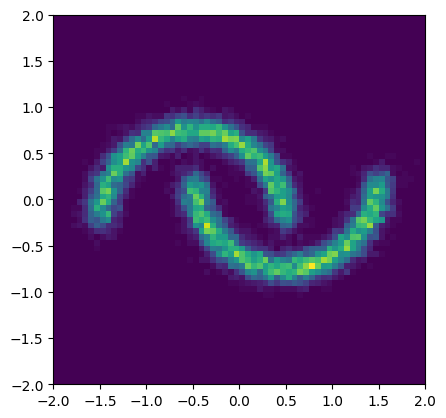

In [4]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [5]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

In [6]:
validationset = data.TensorDataset(*two_moons(16384))
validationloader = data.DataLoader(validationset, batch_size=64, shuffle=True)

## NSF

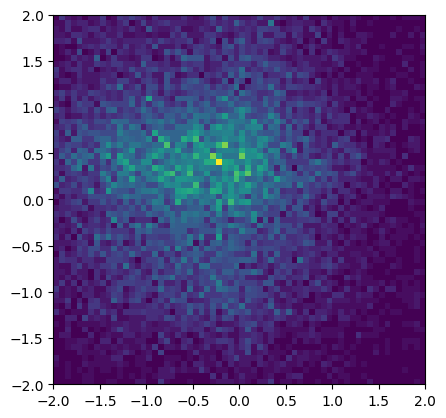

In [7]:
nsf = NSF(x_dim=2, c_dim=1, transforms=3, hidden_features=(64, 64))

fl_sample_0 = nsf.sample(10000, torch.tensor([0.0]).to(next(nsf.parameters()).device))
fl_sample_1 = nsf.sample(10000, torch.tensor([1.0]).to(next(nsf.parameters()).device))
fl_sample = torch.cat([fl_sample_0, fl_sample_1], axis=0).cpu().numpy()

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*fl_sample.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [8]:
nsf.fit(trainloader, validation_dataloader=validationloader, epochs=10)

Epoch 1/10 [train: 0.6728 | val: 0.4470]


Epoch 2/10 [train: 0.4156 | val: 0.3677]


Epoch 3/10 [train: 0.3877 | val: 0.3995]


Epoch 4/10 [train: 0.3826 | val: 0.4016]


Epoch 5/10 [train: 0.3800 | val: 0.3510]


Epoch 6/10 [train: 0.3685 | val: 0.3528]


Epoch 7/10 [train: 0.3657 | val: 0.3641]


Epoch 8/10 [train: 0.3735 | val: 0.4023]


Epoch 9/10 [train: 0.3575 | val: 0.3406]


Epoch 10/10 [train: 0.3571 | val: 0.3531]


{'train_error': [0.6728420678991824,
  0.415622781496495,
  0.3877443360979669,
  0.3825871700537391,
  0.3799946795916185,
  0.3685484059387818,
  0.3657315445598215,
  0.37353999324841425,
  0.35752526979194954,
  0.35710937771364115],
 'val_error': [0.446958307758905,
  0.36769751587416977,
  0.39945978519972414,
  0.40156734525226057,
  0.3510082550928928,
  0.3528083646669984,
  0.3640666559804231,
  0.4022512084338814,
  0.34061511591426097,
  0.35312975535634905]}

In [9]:
%%timeit
fl_sample_0 = nsf.sample(10000, torch.tensor([0.0]).to(next(nsf.parameters()).device))
fl_sample_1 = nsf.sample(10000, torch.tensor([1.0]).to(next(nsf.parameters()).device))

30.9 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


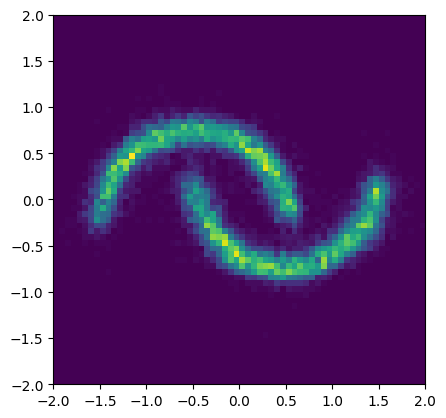

In [10]:
def plot_samples(nsf):

    fl_sample_0 = nsf.sample(10000, torch.tensor([0.0]).to(next(nsf.parameters()).device))
    fl_sample_1 = nsf.sample(10000, torch.tensor([1.0]).to(next(nsf.parameters()).device))
    fl_sample = torch.cat([fl_sample_0, fl_sample_1], axis=0).cpu().numpy()

    plt.figure(figsize=(4.8, 4.8))
    plt.hist2d(*fl_sample.T, bins=64, range=((-2, 2), (-2, 2)))
    plt.show()

plot_samples(nsf)

## UNAF

In [11]:
unaf = UNAF(x_dim=2, c_dim=1, transforms=3, hidden_features=(64, 64))
unaf.fit(trainloader, validation_dataloader=validationloader, epochs=10)

Epoch 1/10 [train: 0.8513 | val: 0.3811]


Epoch 2/10 [train: 0.3769 | val: 0.3452]


Epoch 3/10 [train: 0.3608 | val: 0.3345]


Epoch 4/10 [train: 0.3575 | val: 0.3307]


Epoch 5/10 [train: 0.3505 | val: 0.3430]


Epoch 6/10 [train: 0.3514 | val: 0.3431]


Epoch 7/10 [train: 0.3451 | val: 0.3432]


Epoch 8/10 [train: 0.3427 | val: 0.3572]


Epoch 9/10 [train: 0.3301 | val: 0.3324]


Epoch 10/10 [train: 0.3338 | val: 0.3255]


{'train_error': [0.851273272826802,
  0.3769436696311459,
  0.36075273356982507,
  0.3575329430459533,
  0.3504946517350618,
  0.35136321844765916,
  0.34514890200807713,
  0.34269719777512364,
  0.3300610184087418,
  0.33381555654341355],
 'val_error': [0.3811055805417709,
  0.3451751709799282,
  0.33453054941492155,
  0.33073004764446523,
  0.3430008080031257,
  0.3430695576244034,
  0.34321370531688444,
  0.35721037012990564,
  0.3323965738527477,
  0.3254756961541716]}

In [14]:
%%timeit
fl_sample_0 = unaf.sample(10000, torch.tensor([0.0]).to(next(unaf.parameters()).device))
fl_sample_1 = unaf.sample(10000, torch.tensor([1.0]).to(next(unaf.parameters()).device))

3.03 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


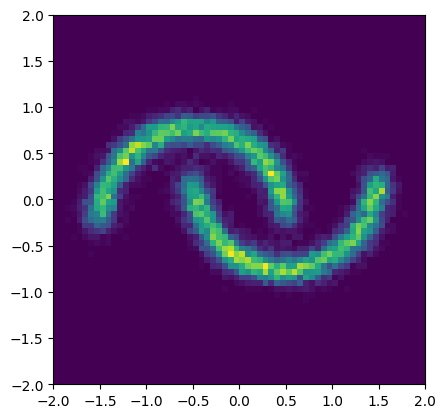

In [13]:
plot_samples(unaf)

## NAF

In [15]:
naf = NAF(x_dim=2, c_dim=1, transforms=3, hidden_features=(64, 64))
naf.fit(trainloader, validation_dataloader=validationloader, epochs=10)

Epoch 1/10 [train: 0.9308 | val: 0.5829]


Epoch 2/10 [train: 0.5672 | val: 0.6492]


Epoch 3/10 [train: 0.5129 | val: 0.4762]


Epoch 4/10 [train: 0.5134 | val: 0.5263]


Epoch 5/10 [train: 0.4785 | val: 0.4750]


Epoch 6/10 [train: 0.4731 | val: 0.4542]


Epoch 7/10 [train: 0.4489 | val: 0.4225]


Epoch 8/10 [train: 0.4276 | val: 0.3816]


Epoch 9/10 [train: 0.4212 | val: 0.4130]


Epoch 10/10 [train: 0.4128 | val: 0.3678]


{'train_error': [0.9307689695851877,
  0.5672004736261442,
  0.5128546297783032,
  0.5133786427322775,
  0.47850144538097084,
  0.4731254265643656,
  0.448947069759015,
  0.4275701835867949,
  0.4211796263116412,
  0.4128395777079277],
 'val_error': [0.5829247608780861,
  0.6492094128625467,
  0.47622804035199806,
  0.5262802761280909,
  0.4750142632983625,
  0.4542356205638498,
  0.4225465750787407,
  0.381619798601605,
  0.41297928302083164,
  0.3678245795890689]}

In [16]:
%%timeit
fl_sample_0 = naf.sample(10000, torch.tensor([0.0]).to(next(naf.parameters()).device))
fl_sample_1 = naf.sample(10000, torch.tensor([1.0]).to(next(naf.parameters()).device))

233 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


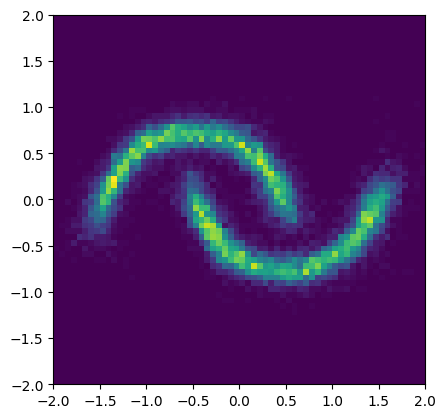

In [17]:
plot_samples(naf)